In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.6
IPython 7.17.0

numpy 1.18.5
pandas 1.1.0
torch 1.5.1


In [2]:
import torch

import os
import numpy as np
import pandas as pd 
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [5]:
HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#93D30C","#8F00FF"]

In [6]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [15]:
'''
下载数据
来自kaggle上的Joe Young的数据集
澳大利亚的天气站的数据集
二分类问题，是否会下雨
共计142193条数据，24个属性
'''
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [16]:
df.shape

(142193, 24)

In [17]:
'''
数据预处理
'''
cols = ['Rainfall','Humidity3pm','Pressure9am','RainToday','RainTomorrow']

In [18]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,0.0,No
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,0.0,No
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,0.0,No
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,0.0,No


In [19]:
'''
这里简化模型，只留五个属性的数据
'''
df = df[cols]

In [20]:
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,No,No
1,0.0,25.0,1010.6,No,No
2,0.0,30.0,1007.6,No,No
3,0.0,16.0,1017.6,No,No
4,1.0,33.0,1010.8,No,No
...,...,...,...,...,...
142188,0.0,27.0,1024.7,No,No
142189,0.0,24.0,1024.6,No,No
142190,0.0,21.0,1023.5,No,No
142191,0.0,24.0,1021.0,No,No


In [21]:
'''
数据需要处理一下，将yes or no的数据转换为0 1数据
'''
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

D:\Software\Anconda\lib\site-packages\pandas\core\series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [22]:
df

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0
1,0.0,25.0,1010.6,0.0,0
2,0.0,30.0,1007.6,0.0,0
3,0.0,16.0,1017.6,0.0,0
4,1.0,33.0,1010.8,0.0,0
...,...,...,...,...,...
142188,0.0,27.0,1024.7,0.0,0
142189,0.0,24.0,1024.6,0.0,0
142190,0.0,21.0,1023.5,0.0,0
142191,0.0,24.0,1021.0,0.0,0


In [23]:
'''
去掉缺失值
'''
df = df.dropna(how='any')

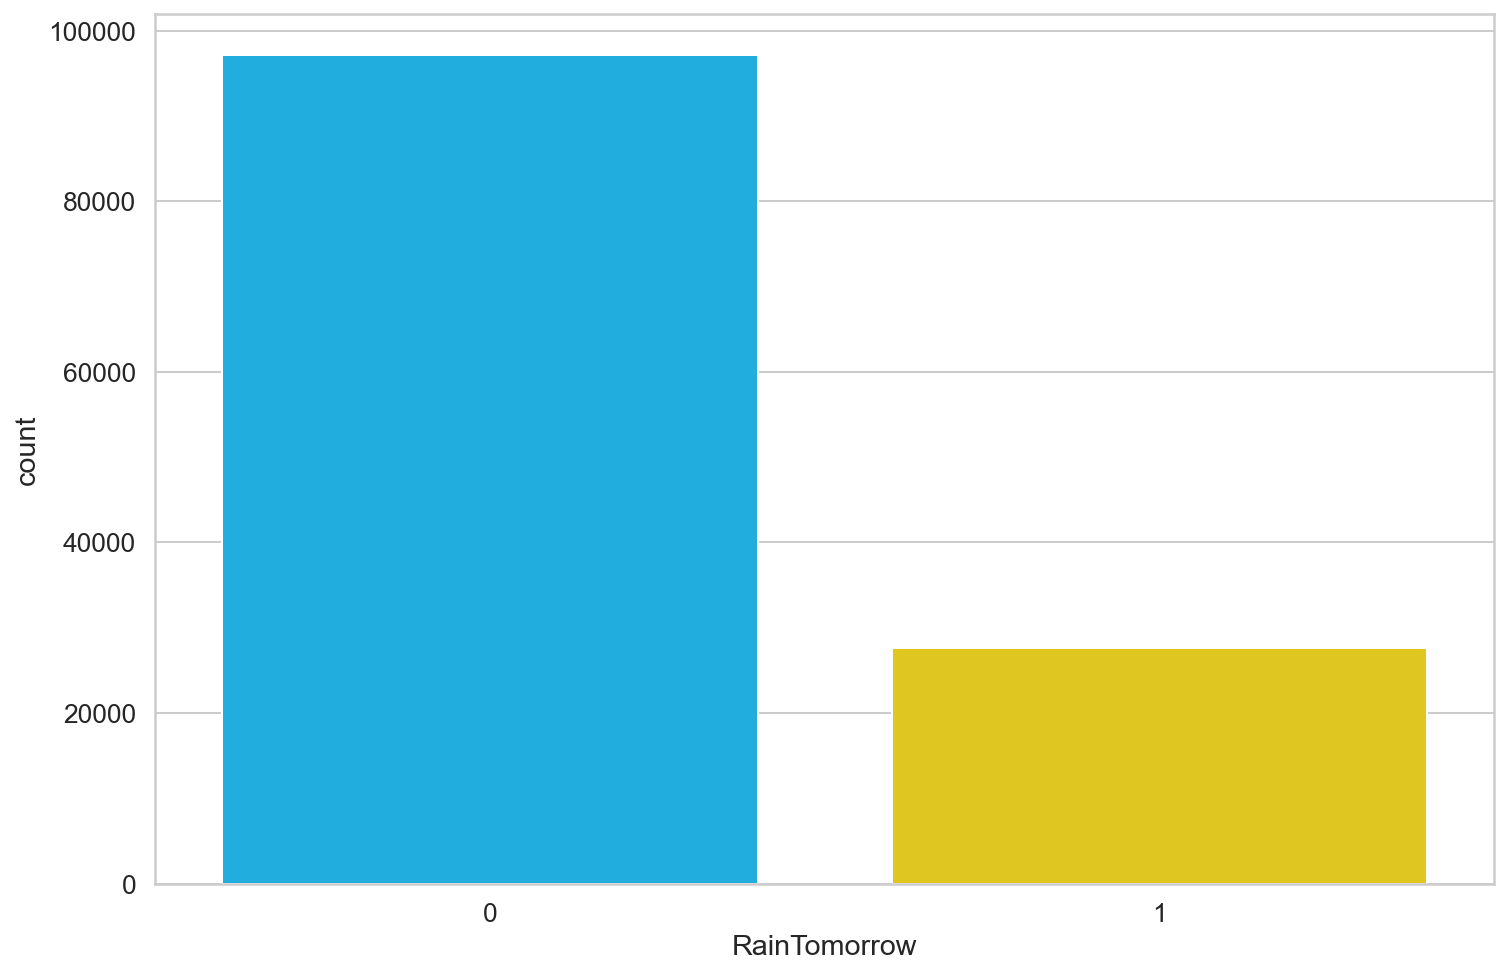

In [24]:
'''
看数据集是否均衡
'''
sns.countplot(df.RainTomorrow)

In [25]:
df.RainTomorrow.value_counts() / df.shape[0]

0    0.778762
1    0.221238
Name: RainTomorrow, dtype: float64

In [26]:
X = df[['Rainfall','Humidity3pm','RainToday','Pressure9am']]
Y = df[['RainTomorrow']]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=RANDOM_SEED)

In [28]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [29]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


In [30]:
'''
下面构建一个NN
全连接网络
input layer 
hidden layer 1
hidden layer 2
output layer
'''
class Net(nn.Module):
    
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features,5)
        self.fc2 = nn.Linear(5,3)
        self.fc3 = nn.Linear(3,1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])

In [31]:
print(net)

Net(
  (fc1): Linear(in_features=4, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


In [31]:
from ann_visualizer.visualize import ann_viz
'''
ann_viz需要另外的一些库依赖，暂时不整
'''

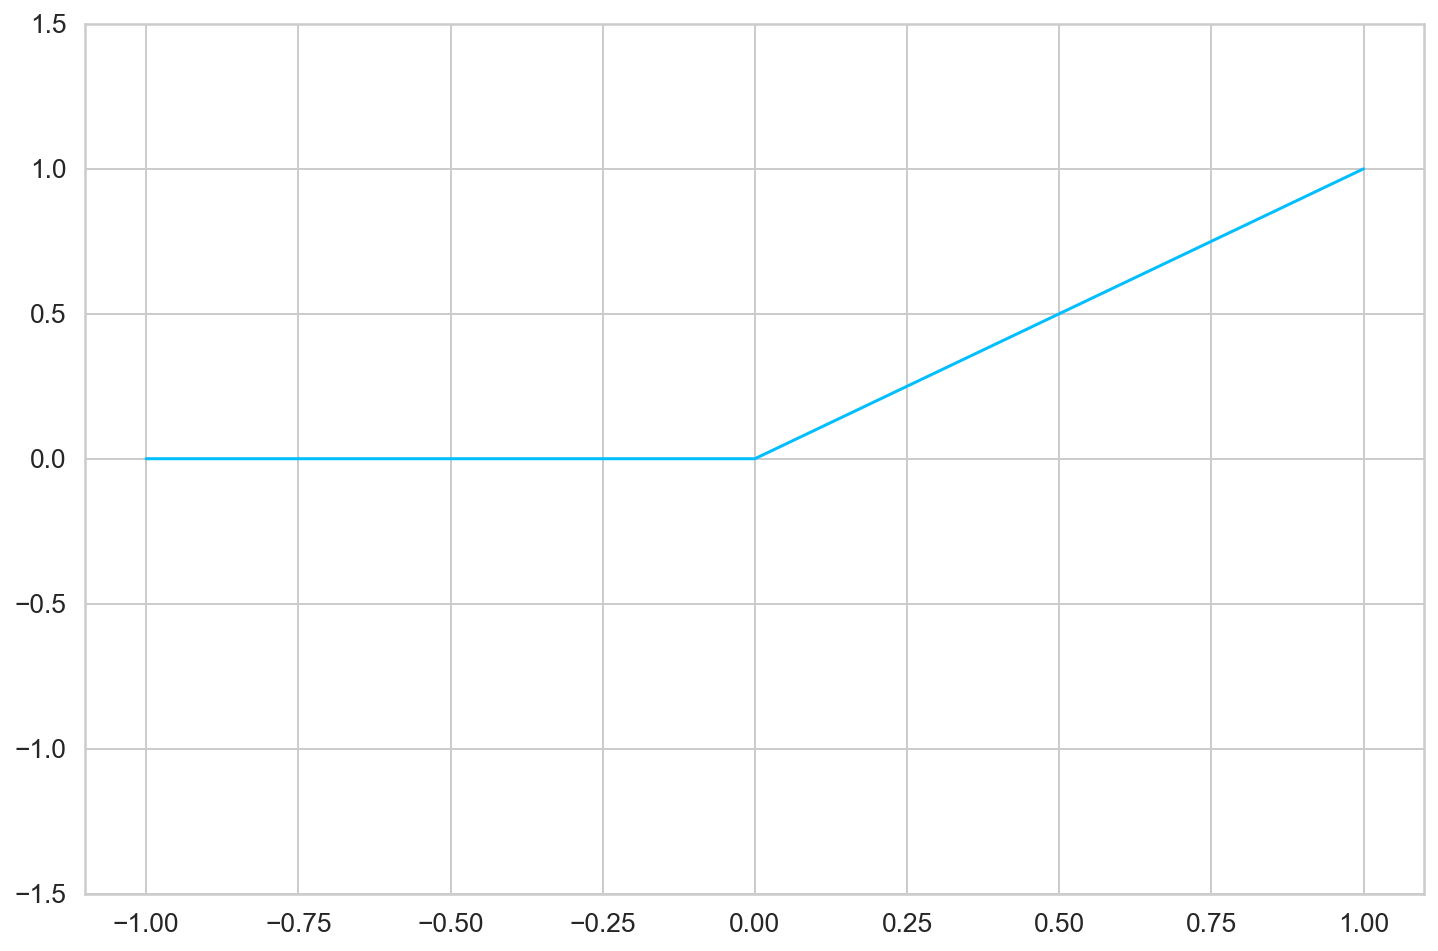

In [32]:
ax = plt.gca()

plt.plot(
    np.linspace(-1,1,5),
    F.relu(torch.linspace(-1,1,steps=5)).numpy()
)
ax.set_ylim([-1.5,1.5]);

D:\Software\Anconda\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


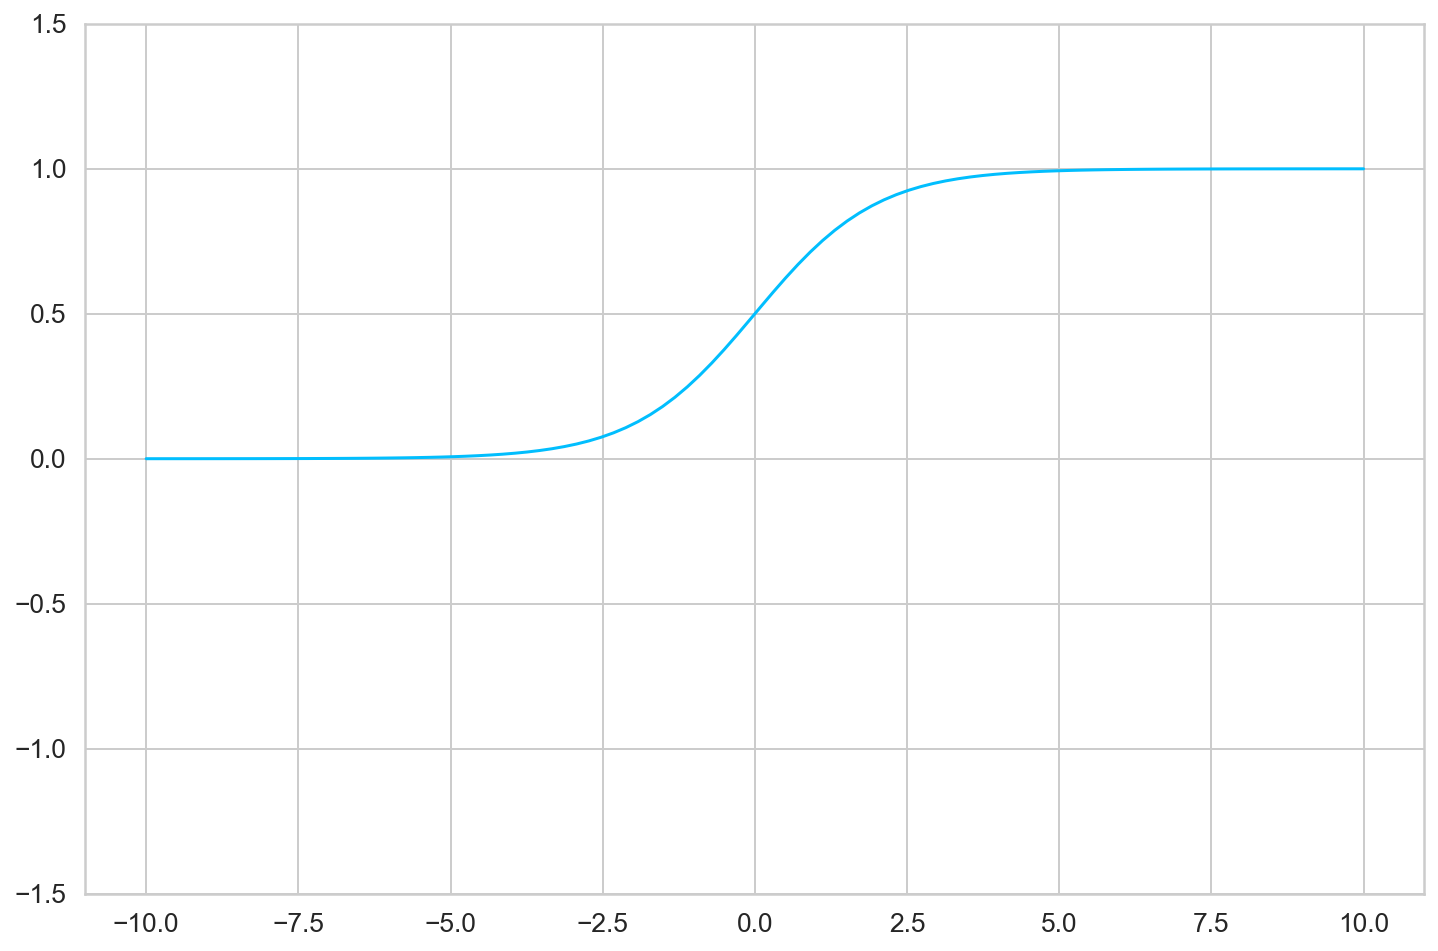

In [34]:
ax = plt.gca()

plt.plot(
    np.linspace(-10,10,100),
    F.sigmoid(torch.linspace(-10,10,steps=100)).numpy()
)
ax.set_ylim([-1.5,1.5]);

In [33]:
criterion = nn.BCELoss()

In [34]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [37]:
net = net.to(device)

criterion = criterion.to(device)

In [38]:
def calculate_acc(y_true,y_pred):
    '''
    将低于0.5的值看作0，其他的情况都看作1
    '''
    #print('y_pred',y_pred)
    predicted = y_pred.ge(.5).view(-1)
    #print('predicted',predicted)
    return (y_true == predicted).sum().float() / len(y_true)

In [39]:
def round_tensor(t, decimal_places = 3):
    return round(t.item(), decimal_places)

In [40]:
for epoch in range(1000):
    
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    #print(y_pred)
    train_loss = criterion(y_pred,y_train)
    #print(train_loss)
    
    if epoch % 100 == 0:
        train_acc = calculate_acc(y_train,y_pred)
        
        y_test_pred = net(X_test)
        y_test_pred = torch.squeeze(y_test_pred)
        
        test_loss = criterion(y_test_pred, y_test)
        
        test_acc = calculate_acc(y_test,y_test_pred)
        print(
f'''epoch {epoch} 
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
'''        )
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0 
Train set - loss: 2.513, accuracy: 0.779
Test  set - loss: 2.517, accuracy: 0.778

epoch 100 
Train set - loss: 0.457, accuracy: 0.792
Test  set - loss: 0.458, accuracy: 0.793

epoch 200 
Train set - loss: 0.435, accuracy: 0.801
Test  set - loss: 0.436, accuracy: 0.8

epoch 300 
Train set - loss: 0.421, accuracy: 0.814
Test  set - loss: 0.421, accuracy: 0.815

epoch 400 
Train set - loss: 0.412, accuracy: 0.826
Test  set - loss: 0.413, accuracy: 0.827

epoch 500 
Train set - loss: 0.408, accuracy: 0.831
Test  set - loss: 0.408, accuracy: 0.832

epoch 600 
Train set - loss: 0.406, accuracy: 0.833
Test  set - loss: 0.406, accuracy: 0.835

epoch 700 
Train set - loss: 0.405, accuracy: 0.834
Test  set - loss: 0.405, accuracy: 0.835

epoch 800 
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.835

epoch 900 
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.836



In [41]:
MODEL_PATH = 'model.pth'

In [42]:
torch.save(net, MODEL_PATH)

D:\Software\Anconda\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [64]:
'''
使用net = torch.load(MODEL_PATH)恢复模型
'''

In [43]:
'''
下面进行模型评估
'''
classes = ['No Rain','Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

In [44]:
print(classification_report(y_test,y_pred,target_names=classes))

              precision    recall  f1-score   support

     No Rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.80      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



观察上面的结果会发现因为数据失衡问题而带来的在少数类样本上的召回率较低的问题。
在判断不下雨的类别上拥有良好的效果，而在判断下雨的类别上效果较差。

In [45]:
confusion_m = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(confusion_m,index=classes,columns=classes)

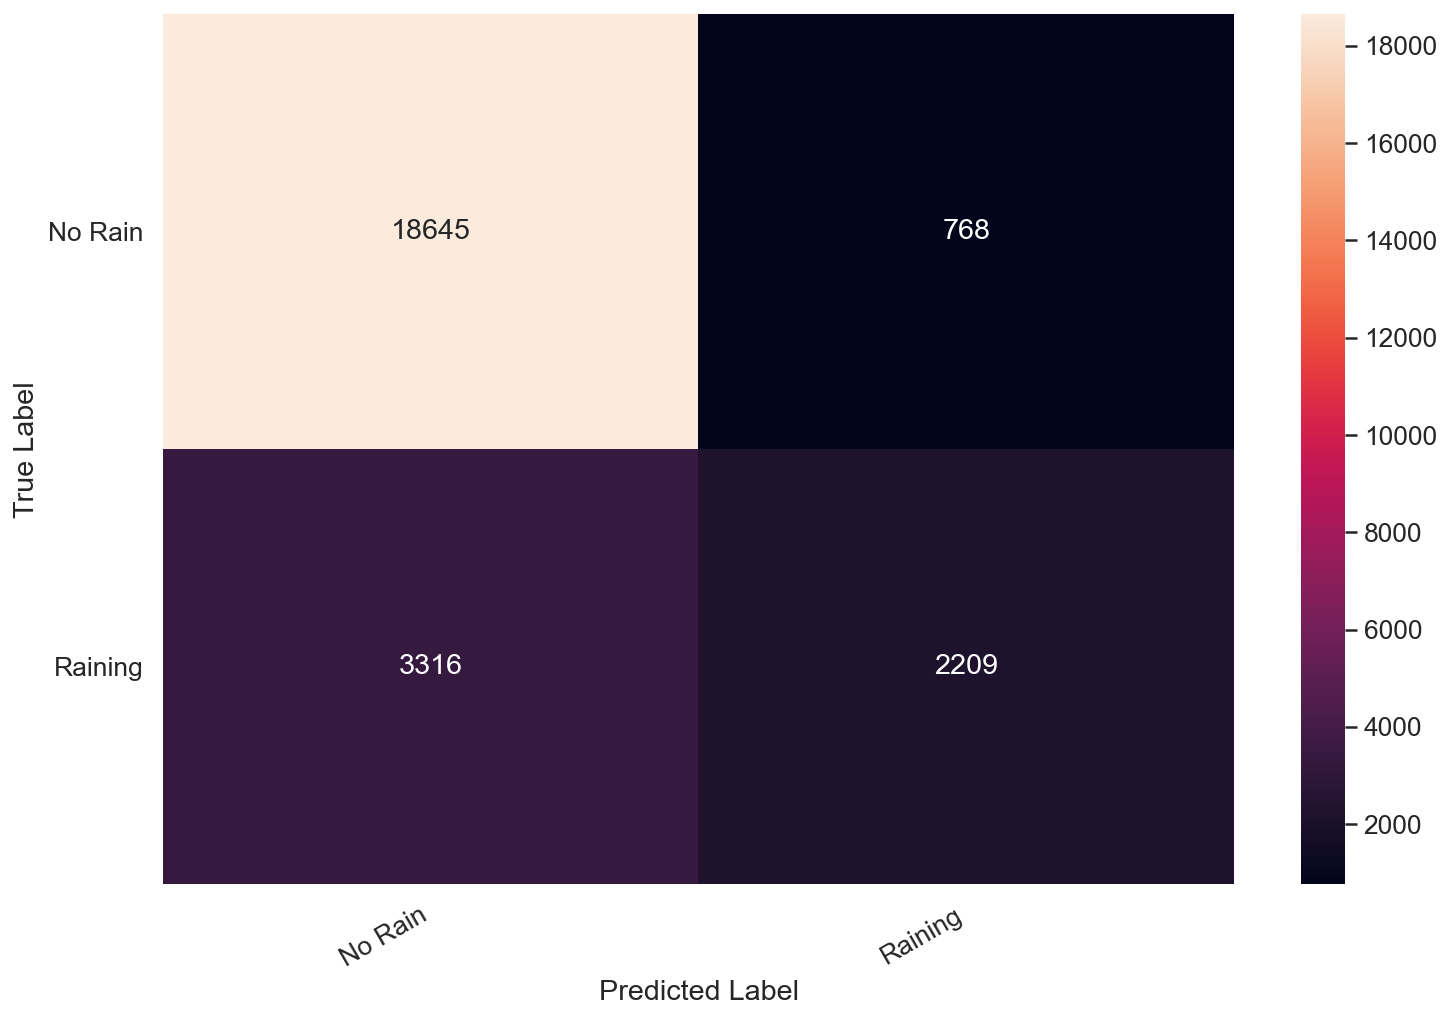

In [46]:
hmap = sns.heatmap(df_cm,annot=True,fmt='d')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0,ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=30,ha='right')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');

1. 数据预处理以及将数据导入为tensor结构
2. 使用pytorch构建简单的NN
3. Binary Cross-Entropy Loss
4. 模型评估